In [2]:
import utils
utils.assign_free_gpus()
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

Using GPU index: 0


### Dataset

In [3]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 28, 28]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: 0.0


In [4]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 10)
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

In [5]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [6]:
# Hyperparameters
learning_rate = .0192
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

### Train model

In [7]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:07<00:00, 118.30it/s]


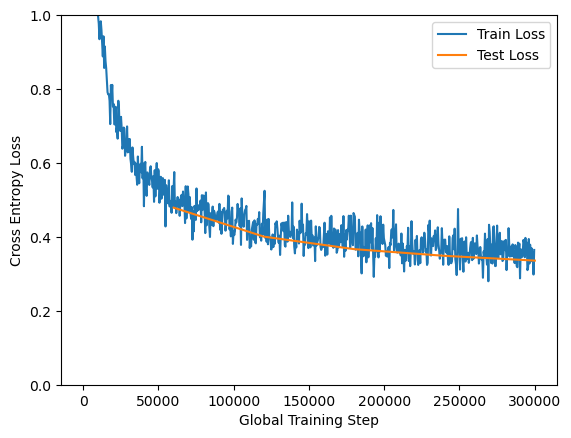

Final Test loss: 0.33583178781684797. Final Test accuracy: 0.9084


In [8]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task A

In [11]:
#Normalizing
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize(mean=(example_images.mean().item(),), std=(example_images.std().item(),)),
    torchvision.transforms.Normalize(0.5, 0.5) #Normalize between [-1, 1]
])
dataloader_train_norm, dataloader_test_norm = dataloaders.load_dataset(batch_size, image_transform)

#Training
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train_norm,
  dataloader_test=dataloader_test_norm,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_norm, test_loss_dict_norm = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:11<00:00, 82.13it/s]


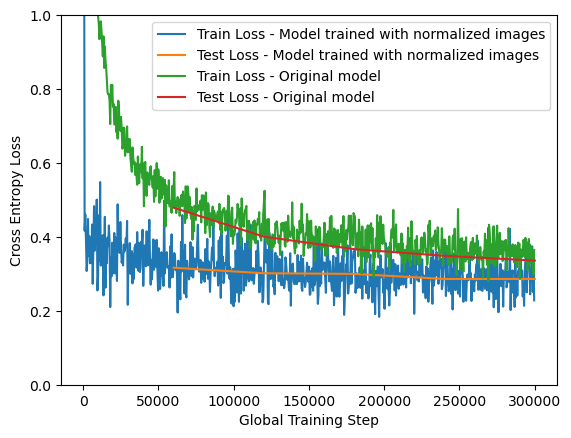

Final Test loss: 0.28619602989927406. Final Test accuracy: 0.921


In [12]:
#Plot loss
utils.plot_loss(train_loss_dict_norm, label="Train Loss - Model trained with normalized images")
utils.plot_loss(test_loss_dict_norm, label="Test Loss - Model trained with normalized images")
utils.plot_loss(train_loss_dict, label="Train Loss - Original model")
utils.plot_loss(test_loss_dict, label="Test Loss - Original model")

# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")

plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test_norm, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task B

In [13]:
###THIS ONE SAVES IMAGES AND CANT PRINT LAST IMAGE###

#weight = list(model.children())[1].weight.cpu().data
#print(weight)
#print(weight.shape)
#print(weight[9].shape)

#import pathlib
#output_dir = pathlib.Path("image_solutions")

#fix, axes = plt.subplots(2, 5, figsize=(20,10))
#for i in range(9, 0, -1):
#    ax = axes[i//5, i%5] #Fit all the images
#    img_data = weight[i].view(28,28) #Put all image data in 28x28 format
#    utils.save_im(output_dir.joinpath('weight_digit_'+str(i)+'.png'), img_data)
#    ax.imshow(img_data, cmap='gray')
 #   ax.set_title(f"Digit {i}")
#   ax.axis('off')

#plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.imshow(weight)

IndexError: index 2 is out of bounds for axis 0 with size 2

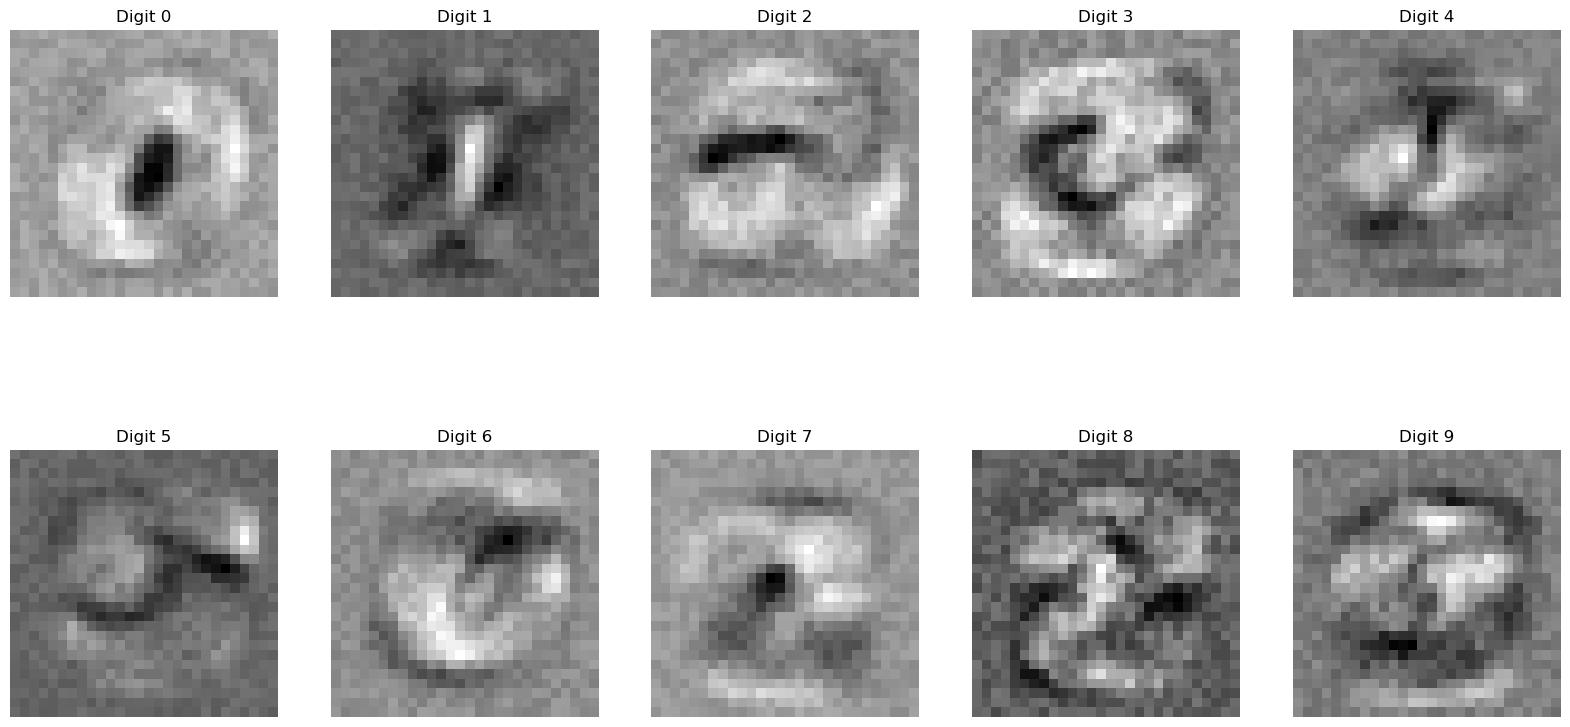

In [14]:
###THIS ONE DOES NOT SAVE IMAGES AND CAN PRINT LAST IMAGE, BUT THROWS AN ERROR!! NB, must run all remaining cells after the crash occurs###

weight = list(model.children())[1].weight.cpu().data

fix, axes = plt.subplots(2, 5, figsize=(20,10))
for i in range(11):
    ax = axes[i//5, i%5] #Fit all the images
    img_data = weight[i].view(28,28) #Put all image data in 28x28 format
    ax.imshow(img_data, cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.imshow(weight)

### Task C

In [16]:
#Updating learning rate
learning_rate = 1.0

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

dataloader_train_norm_learning_rate_1, dataloader_test_norm_learning_rate_ = dataloaders.load_dataset(batch_size, image_transform) #image_transform already normalized

#Training
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train_norm,
  dataloader_test=dataloader_test_norm,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_norm_learning_rate_1, test_loss_dict_norm_learning_rate_1 = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:11<00:00, 83.10it/s]


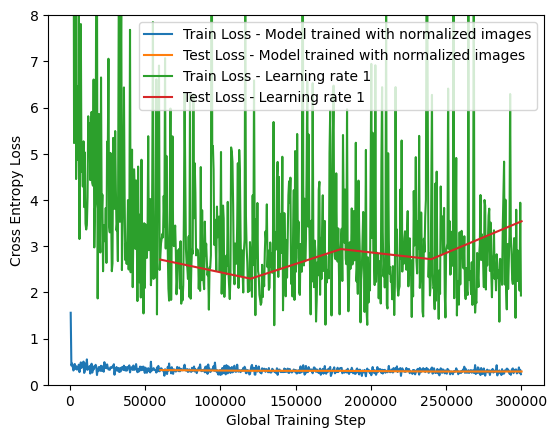

Final Test loss: 3.5377061536452574. Final Test accuracy: 0.822


In [20]:
#Plot loss
utils.plot_loss(train_loss_dict_norm, label="Train Loss - Model trained with normalized images")
utils.plot_loss(test_loss_dict_norm, label="Test Loss - Model trained with normalized images")
utils.plot_loss(train_loss_dict_norm_learning_rate_1, label="Train Loss - Learning rate 1")
utils.plot_loss(test_loss_dict_norm_learning_rate_1, label="Test Loss - Learning rate 1")

# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 8])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4c.png")

plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test_norm_learning_rate_, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task D

In [24]:
def create_model_hiddenlayer():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 64),
        # No need to include softmax, as this is already combined in the loss function
        nn.ReLU(), #Use ReLU for first layer
        nn.Linear(64, 10), #Add another layer with 64 nodes and 10 channels
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model_hiddenlayer()

In [25]:
#Resetting learning rate
learning_rate = .0192

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)


dataloader_train_norm_hidden, dataloader_test_norm_hidden = dataloaders.load_dataset(batch_size, image_transform)

#Training
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train_norm,
  dataloader_test=dataloader_test_norm,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_norm_hidden, test_loss_dict_norm_hidden = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 938/938 [00:11<00:00, 78.21it/s]


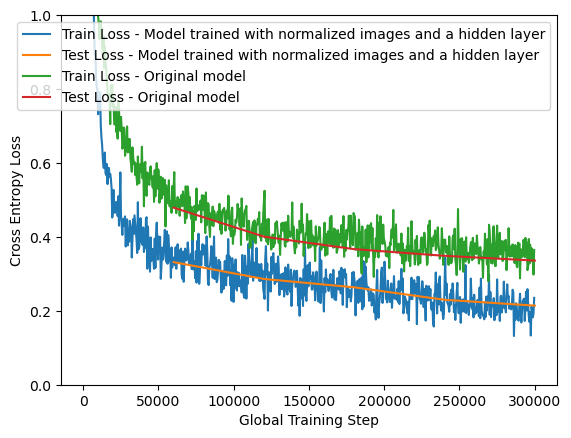

Final Test loss: 0.21401321492306177. Final Test accuracy: 0.9373


In [28]:
#Plot loss
utils.plot_loss(train_loss_dict_norm_hidden, label="Train Loss - Model trained with normalized images and a hidden layer")
utils.plot_loss(test_loss_dict_norm_hidden, label="Test Loss - Model trained with normalized images and a hidden layer")
utils.plot_loss(train_loss_dict, label="Train Loss - Original model")
utils.plot_loss(test_loss_dict, label="Test Loss - Original model")

# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4d.png")

plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test_norm_hidden, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")